# Determining the age of buyers using computer vision

### Project description

A chain supermarket is implementing a computer vision system to process customer photos. Photo recording in the checkout area will help determine the age of customers in order to:
Analyze purchases and offer products that may be of interest to buyers of this age group;
Monitor the integrity of cashiers when selling alcohol.
The task is to build a model that, from a photograph, determines the approximate age of a person.

- We have at our disposal a set of photographs of people indicating their age.
- A folder with all images and a CSV file labels.csv with two columns: file_name and real_age.

The model is trained in a separate GPU simulator, and the result of displaying the model on the screen is saved.

### Exploratory Data Analysis

**We will conduct an exploratory data analysis:
Let's look at the sample size.
Let's plot the age distribution in the sample.
Let’s print 10–15 photos on the screen and see how the dataset works.**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import random
import os

from google.colab import drive

In [ ]:
csv_path = '/content/drive/My Drive/projects/age_prediction_with_CNN/gt_train.csv'
img_path = '/content/drive/My Drive/projects/age_prediction_with_CNN/train'
drive.mount('/content/drive')
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(csv_path)
target = df[['file_name', 'real_age']].drop_duplicates().reset_index(drop=True)

**Let's look at the contents of the target csv file.**

In [ ]:
target.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4113 entries, 0 to 4112
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  4113 non-null   object
 1   real_age   4113 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 64.4+ KB


In [ ]:
target.describe()

,real_age
count,4113.000000
mean,30.476052
std,16.312428
min,1.000000
25%,19.000000
50%,28.000000
75%,40.000000
max,100.000000


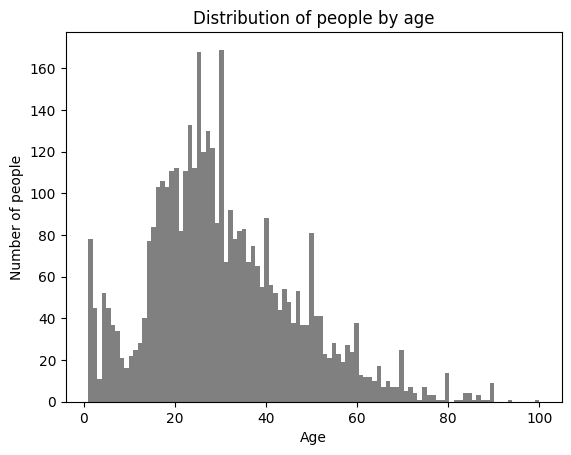

In [ ]:
plt.hist(target['real_age'], bins=100, color='gray');
plt.xlabel('Age')
plt.ylabel('Number of people')
plt.title('Distribution of people by age')
plt.show()

**We can see a fairly large number of images corresponding to an age of less than 10 years. Let's see what percentage of all available images this is.**

In [ ]:
round(len(target[target['real_age'] < 10])/len(target),3)

0.082

**We've got 8.2%, which is not little.**

**Let's check whether all the files specified in the dataframe are actually in the folder with images.**

In [ ]:
folder_files = os.listdir(img_path)
df=target.copy()
df_files = pd.DataFrame({'file_name': folder_files})
missing_files = df[~df['file_name'].isin(df_files['file_name'])]
print('Missing files:')
print(missing_files['file_name'])

Missing files:
Series([], Name: file_name, dtype: object)


**There are no gaps in the data, all the image names specified in the target csv file are actually in the folder with the images.**

**We will select and display 15 random photos from the training set that correspond to an age value of less than 10 years, to check for errors in the data (the photos do not correspond to the specified age).**

Image name: 004175.jpg, Age: 9


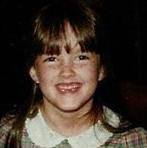

Image name: 004416.jpg, Age: 3


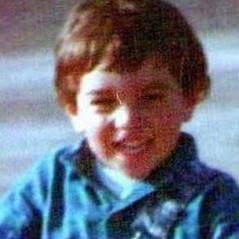

Image name: 001651.jpg, Age: 4


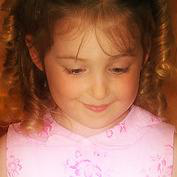

Image name: 002109.jpg, Age: 6


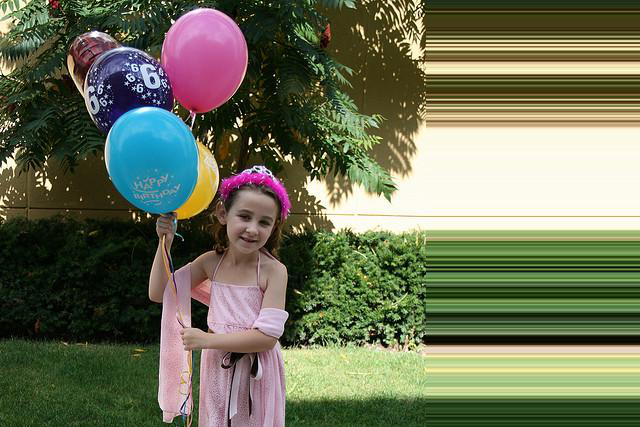

Image name: 007136.jpg, Age: 7


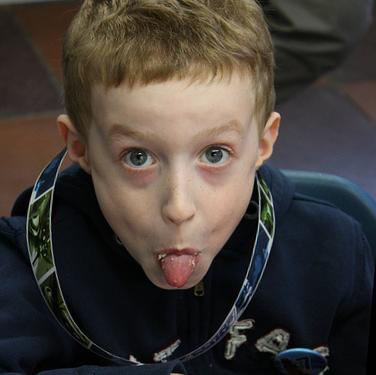

Image name: 005792.jpg, Age: 4


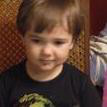

Image name: 002926.jpg, Age: 9


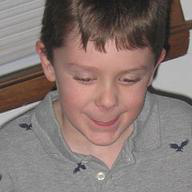

Image name: 005097.jpg, Age: 1


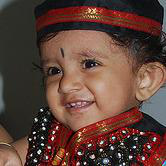

Image name: 000803.jpg, Age: 2


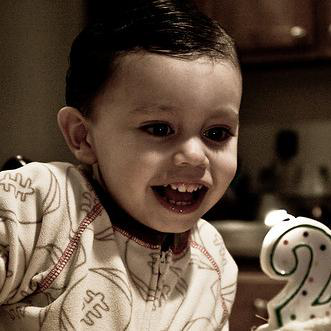

Image name: 001370.jpg, Age: 8


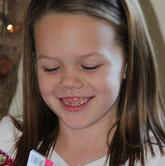

Image name: 001017.jpg, Age: 5


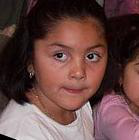

Image name: 005800.jpg, Age: 4


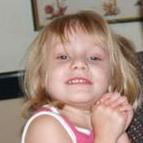

Image name: 006868.jpg, Age: 7


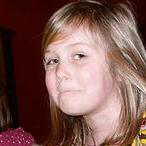

Image name: 004329.jpg, Age: 5


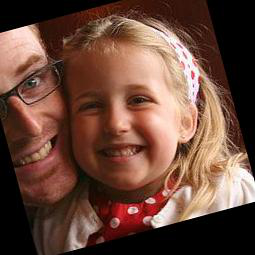

Image name: 003754.jpg, Age: 5


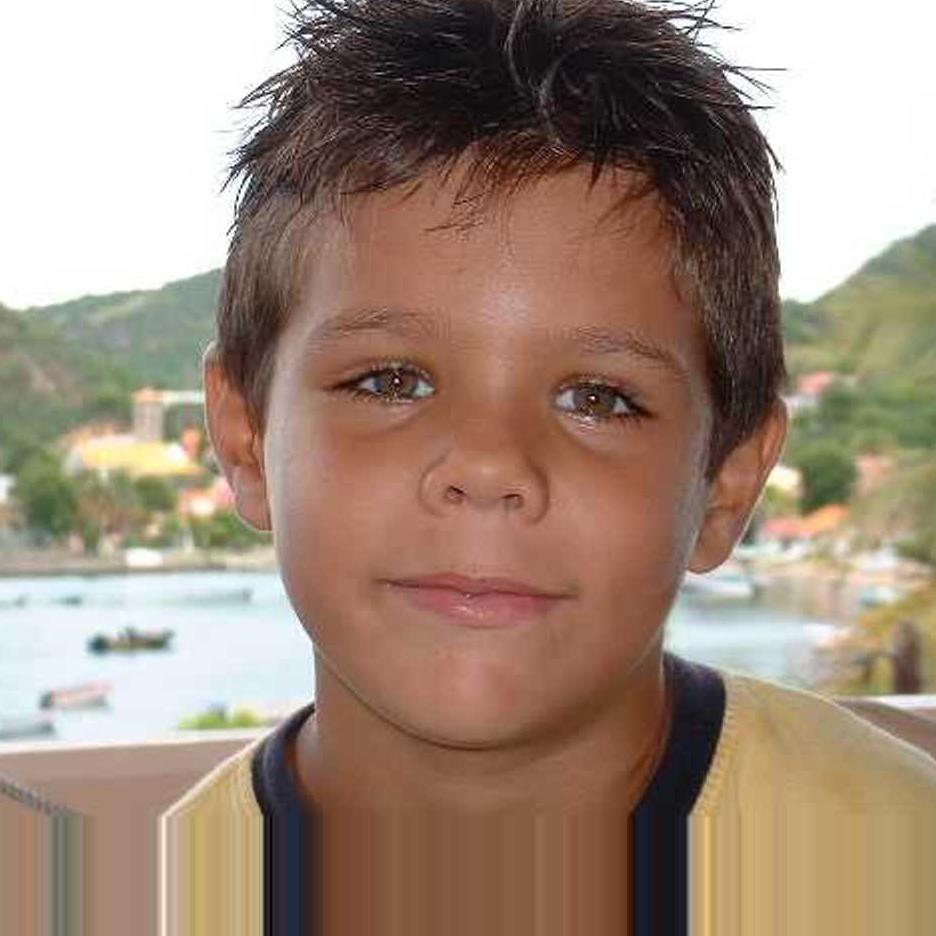

In [ ]:
df_filtered = df[df['real_age'] < 10]
selected_images = random.sample(list(df_filtered['file_name']), 15)

for img_name in selected_images:
    path = img_path + img_name
    img = Image.open(path)
    img_age = df[df['file_name'] == img_name]['real_age'].values[0]
    print(f"Image name: {img_name}, Age: {img_age}")
    img.show()

### Section output

**No erroneous data was found in this random sample of images, we can conclude that the data does indeed correspond to children in the younger age group.**

**Based on the goals of the task - to determine the age of clients in order to:**

**(1) Analyze purchases and suggest products that may be of interest to buyers of this age group;**

**(2) Monitor the integrity of cashiers when selling alcohol.**

**We can conclude that we are not interested in including images of children in the younger age group in the training sample, because These customers are very likely to be with adults at the checkout, i.e. It will be necessary to analyze purchases for subsequent offers of goods for these same adults, and the cashier will not sell alcohol/cigarettes to such people in any case, even if they are alone at the checkout. It will be necessary to exclude people in the younger age group from the training sample.**

**At the same time, you can also note that the folder contains photos of different resolutions; when training the model, we will need to bring all the photos to the same resolution. At the same time, when bringing some photos to the same resolution (square proportions, for example), we can get distortions that especially clearly affect people’s faces, which can negatively affect the correctness of model training.**

## Model training

**For our task we will use the pre-trained ResNet50 model. In this case, we will turn off the last layer of the original ResNet50 model to obtain a regression model with one neuron and ReLU activation, since In our task it is necessary to determine continuous numerical values - the age of a person. We will use ReLU activation, because The ReLU function does not change positive predictions of the network, but leads to zero all negative ones. There cannot be numbers less than 0 in this problem. We will use the MSE loss function for faster model training, and the metric - MAE according to the problem conditions. Below is the model code using functions for conducting training on an external server.**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path):
    train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(path+'labels.csv'),
    directory=path+'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    seed=12345,
    subset='training',
    class_mode='raw')
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(path+'labels.csv'),
    directory=path+'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    seed=12345,
    subset='validation',
    class_mode='raw')
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0001), metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=6,
               steps_per_epoch=None, validation_steps=None):
    train_datagen_flow=train_data
    test_datagen_flow=test_data
    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs, batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

The code in this section runs on a separate server with a GPU, so it is not formatted as a cell with code, but as code in a text cell

```

- Train for 356 steps, validate for 119 steps
- Epoch 1/6
- 356/356 - 75s - loss: 251.5800 - mae: 11.5580 - val_loss: 730.1034 - val_mae: 22.0478
- Epoch 2/6
- 356/356 - 39s - loss: 73.9373 - mae: 6.5915 - val_loss: 148.6889 - val_mae: 9.2627
- Epoch 3/6
- 356/356 - 39s - loss: 37.5070 - mae: 4.6956 - val_loss: 94.8892 - val_mae: 7.2627
- Epoch 4/6
- 356/356 - 41s - loss: 22.2213 - mae: 3.6469 - val_loss: 80.8747 - val_mae: 6.7367
- Epoch 5/6
- 356/356 - 38s - loss: 15.3772 - mae: 2.9839 - val_loss: 85.4200 - val_mae: 6.9597
- Epoch 6/6
- 356/356 - 38s - loss: 11.8531 - mae: 2.6278 - val_loss: 70.8848 - val_mae: 6.3515

- 119/119 - 10s - loss: 70.8848 - mae: 6.3515
- Test MAE: 6.3515

```

## Analysis of the trained model

**It was possible to obtain a MAE value of 6.3515 for 6 epochs with the Adam optimizer at a value of learning rate = 0.0001, which satisfies the task and is a fairly good result.**

**In the case of a real task, we would filter the images by age, as I noted earlier, and would also pre-process the images on which we carried out training and validation, bringing their proportions to a square (our target_size has square proportions), replacing "empty" parts of such modified photos with a white background - 0 values in the NumPy matrix.**